### Types of gym_bandits
`BanditTwoArmedDeterministicFixed-v0`: Simplest case where one bandit always pays, and the other always doesn't

`BanditTwoArmedHighLowFixed-v0`: Stochastic version with a large difference between which bandit pays out of two choices

`BanditTwoArmedHighHighFixed-v0`: Stochastic version with a small difference between which bandit pays where both are good

`BanditTwoArmedLowLowFixed-v0`: Stochastic version with a small difference between which bandit pays where both are bad

`BanditTenArmedRandomFixed-v0`: 10 armed bandit with random probabilities assigned to payouts

`BanditTenArmedRandomRandom-v0`: 10 armed bandit with random probabilities assigned to both payouts and rewards

`BanditTenArmedUniformDistributedReward-v0`: 10 armed bandit with that always pays out with a reward selected from a uniform distribution

`BanditTenArmedGaussian-v0`: 10 armed bandit mentioned on page 30 of Reinforcement Learning: An Introduction (Sutton and Barto)

----------

#### References
- gym_bandits library from https://github.com/JKCooper2/gym-bandits
- moving average function https://github.com/klangner/rl-examples/blob/master/notebooks/openai-gym/%5Bnot%20solved%5D%20CartPole.ipynb

In [3]:
import gym_bandits
import gym
import matplotlib.pyplot as plt
from numpy import argmax, random, cumsum

In [74]:
env = gym.make("BanditTenArmedGaussian-v0")
env.reset()

[2018-01-17 10:07:11,750] Making new env: BanditTenArmedGaussian-v0


0

In [75]:
# helper functions

def moving_average(xs, n=100):
    ret = cumsum(xs, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def get_average(xs):
    output = [1] * len(xs)
    for n in range(1, len(xs) + 1):
        output[n-1] = float(xs[n-1]) / (n)
    return output

def to_percent(xs):
    for n in range(len(xs)):
        xs[n] = float(xs[n]) / (n + 1)
    return xs

In [76]:
# defining the agent

class SimpleAgent(object):
    def __init__(self, num_actions, Q_init=0):
        self.num_actions = num_actions
        self.A = range(num_actions)
        self.N = [0] * num_actions # the number of times N(a) has been called
        self.Q = [Q_init] * num_actions # the expected value of choosing Q(a)
    
    def choose_action(self, epsilon): # choose random action with probability epsilon        
        rand = random.rand()
        if (rand < epsilon):
            choice = random.choice(self.A)
            return choice
        else:
            choice = argmax(self.Q)
            return choice
    
    def learn(self, action, reward): # update Q and N
        self.N[a] += 1
        self.Q[a] += (1 / self.N[a]) * (reward - self.Q[a])
    
    def alpha_learn(self, action, reward, alpha=0.1): # update Q and N
        self.N[a] += 1
        self.Q[a] += alpha * (reward - self.Q[a])
    

In [77]:
# get reward distribution

r_dist = list(map(lambda x: x[0], env.env.r_dist))
    
optimal_choice = argmax(r_dist)
print("optimal choice is action at index:", optimal_choice)
print("reward distribution:", r_dist)


optimal choice is action at index: 5
reward distribution: [0.9389538508316365, -0.3877202040348384, 0.33210739552346275, 0.445058401365293, -0.497582037728342, 1.4589924975513806, -0.6865920452335534, -0.09958264790328553, -1.1748381451787961, -0.9648320795887807]


In [78]:
# event loop for timesteps t

agent = SimpleAgent(env.action_space.n)
e = 0.05 # epsilon factor for exploration
 
total_reward = 0
total_rewards = []
rewards = []

optimal_picks = 0
optimal_tracker = []

for t in range(10000):
    a = agent.choose_action(e)
    if a == optimal_choice: optimal_picks += 1
    optimal_tracker.append(optimal_picks)
    
    observation, reward, done, info = env.step(a)
    total_reward += reward
    rewards.append(reward)
    total_rewards.append(total_reward)
    agent.alpha_learn(a, reward)


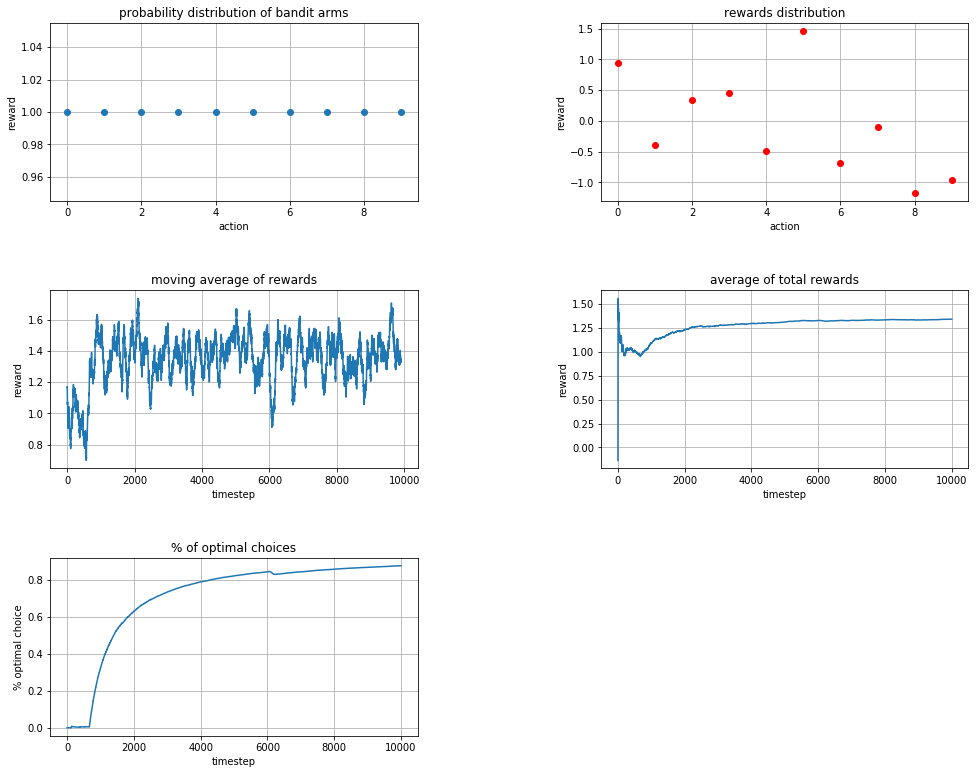

In [79]:
# plotting

plt.figure(1, figsize=(15,10))

# probability distribution
plt.subplot(321)
plt.plot(env.env.p_dist, 'o')
plt.title('probability distribution of bandit arms')
plt.xlabel('action')
plt.ylabel('reward')
plt.grid(True)


# reward distribution
plt.subplot(322)
plt.plot(r_dist, 'ro')
plt.title('rewards distribution')
plt.xlabel('action')
plt.ylabel('reward')
plt.grid(True)


# moving average of rewards
plt.subplot(323)
plt.plot(moving_average(rewards))
plt.title('moving average of rewards')
plt.xlabel('timestep')
plt.ylabel('reward')
plt.grid(True)

# moving average of total rewards
plt.subplot(324)
plt.plot(get_average(total_rewards))
plt.title('average of total rewards')
plt.xlabel('timestep')
plt.ylabel('reward')
plt.grid(True)

# % of optimal choices
plt.subplot(325)
plt.plot(to_percent(optimal_tracker))
plt.title('% of optimal choices')
plt.xlabel('timestep')
plt.ylabel('% optimal choice')
plt.grid(True)

plt.subplots_adjust(top=0.99, bottom=.0, left=0.10, right=0.95, hspace=0.5,
                    wspace=0.5)

plt.show()